In [20]:
import os
import numpy as np
from ml_pi_predictor_2 import ViscoelasticDataset, VE_TimeIntegrationPredictor
import torch
from pathlib import Path
from scipy.stats import pearsonr

# temporary solution:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # to avoid  OpenMP Conflicts
# OpenMP (Open Multi-Processing) is a parallel computing API
# used to speed up computations by running code on multiple CPU cores simultaneously.
import matplotlib.pyplot as plt


In [21]:
# Define data directory

data_root_dir = Path(os.path.expanduser("~")) / "bmcs_training_data"
new_data_root_dir = Path(os.path.expanduser("~")) / "bmcs_validating_data"
dataset = ViscoelasticDataset(data_root_dir, normalize=True)


Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.1A\Pi_data_10C_0.1A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.2A\Pi_data_10C_0.2A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.3A\Pi_data_10C_0.3A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.4A\Pi_data_10C_0.4A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.5A\Pi_data_10C_0.5A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.6A\Pi_data_10C_0.6A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.7A\Pi_data_10C_0.7A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.8A\Pi_data_10C_0.8A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.9A\Pi_data_10C_0.9A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_1.0A\Pi_data_10C_1.0A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_1.1A\Pi_data_10C_1.1A.npy
Loading data from: C:

In [22]:
sample_data_1_path = Path("C:/Users/A_structure/bmcs_validating_data/HHLL_4C_1A_20S/Pi_data_HHLL_4C_1A_20S.npy")
sample_data_2_path = Path("C:/Users/A_structure/bmcs_validating_data/2.5C_1.45A_40S/Pi_data_2.5C_1.45A_40S.npy")
sample_data_1 = np.load(sample_data_1_path)
sample_data_2 = np.load(sample_data_2_path)


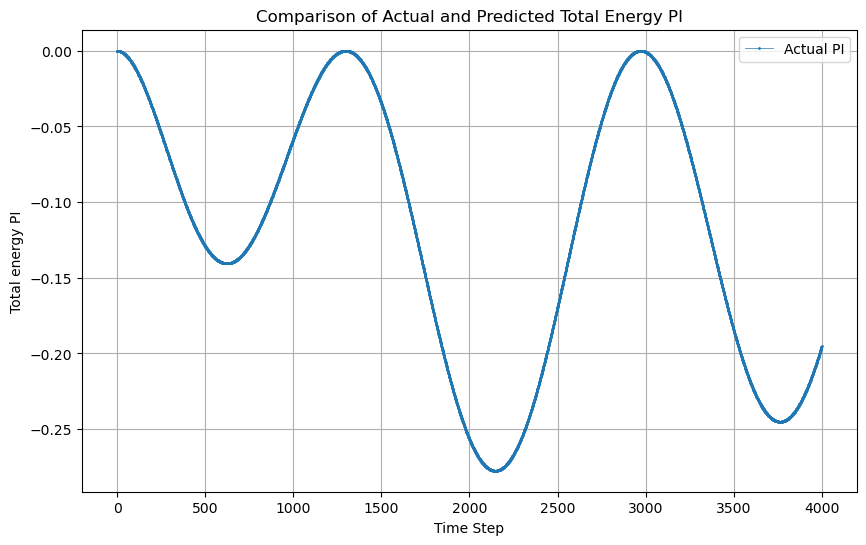

In [27]:
# Load sample data
sample_data = sample_data_2

eps_t = sample_data[:, 0]  
dd_eps_t = sample_data[:, 1]  
eps_v_t = sample_data[:, 2]  
d_t = sample_data[:, 3]  
pi_n1 = sample_data[:, 4]  # Actual values

# Normalize inputs
mean = dataset.mean
std = dataset.std

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_1 = VE_TimeIntegrationPredictor().to(device)
model_1.load_state_dict(torch.load("ve_pi_p_e100_b2000_false_.pth", map_location=device))
model_1.eval()

model_2 = VE_TimeIntegrationPredictor().to(device)
model_2.load_state_dict(torch.load("ve_pi_p_e100_b2000_true_.pth", map_location=device))
model_2.eval()

model_3 = VE_TimeIntegrationPredictor().to(device)
model_3.load_state_dict(torch.load("ve_pi_p_e100_b100_false_.pth", map_location=device))
model_3.eval()

model_4 = VE_TimeIntegrationPredictor().to(device)
model_4.load_state_dict(torch.load("ve_pi_p_e100_b100_true_.pth", map_location=device))
model_4.eval()


# Initialize lists for predictions
predictions_1 = []
predictions_2 = []
predictions_3 = []
predictions_4 = []


# Iterate through each data point
for i in range(len(eps_t)):
    input_vector = np.array([[eps_t[i], dd_eps_t[i], eps_v_t[i], d_t[i]]])
    input_normalized = (input_vector - mean) / std
    input_tensor = torch.tensor(input_normalized, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        pred_1 = model_1(input_tensor).cpu().numpy().flatten()[0]
        pred_2 = model_2(input_tensor).cpu().numpy().flatten()[0]
        pred_3 = model_3(input_tensor).cpu().numpy().flatten()[0]
        pred_4 = model_4(input_tensor).cpu().numpy().flatten()[0]
        
    predictions_1.append(pred_1)
    predictions_2.append(pred_2)
    predictions_3.append(pred_3)
    predictions_4.append(pred_4)


# Convert lists to numpy arrays
predictions_1 = np.array(predictions_1)
predictions_2 = np.array(predictions_2)
predictions_3 = np.array(predictions_3)
predictions_4 = np.array(predictions_4)


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(pi_n1, label='Actual PI', linestyle='-', marker='o', markersize=1, linewidth=0.5)
# plt.plot(predictions_1 - predictions_1[0] , label='Predicted PI (Model 1 - E100, B2000 - not shuffled)', linestyle='--', marker='x', markersize=1, linewidth=0.5)
# plt.plot(predictions_2 - predictions_2[0], label='Predicted PI (Model 2 - E100, B2000 - shuffled)', linestyle='--', marker='x', markersize=1, linewidth=0.5)
# plt.plot(predictions_3 - predictions_3[0], label='Predicted PI (Model 3 - E100, B100 - not shuffled)', linestyle='--', marker='x', markersize=1, linewidth=0.5)
# plt.plot(predictions_4 - predictions_4[0], label='Predicted PI (Model 4 - E100, B100 - shuffled)', linestyle='--', marker='x', markersize=1, linewidth=0.5)

plt.xlabel("Time Step")
plt.ylabel("Total energy PI")
plt.legend()
plt.title("Comparison of Actual and Predicted Total Energy PI")
plt.grid()
plt.show()


C:\Users\A_structure\AppData\Local\Temp\ipykernel_22200\1425766768.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(pi_n1, predictions_1)


MSE: 0.019206
RMSE: 0.138585
MAE: 0.116428
R^2: -1.432324
Pearson Correlation: nan


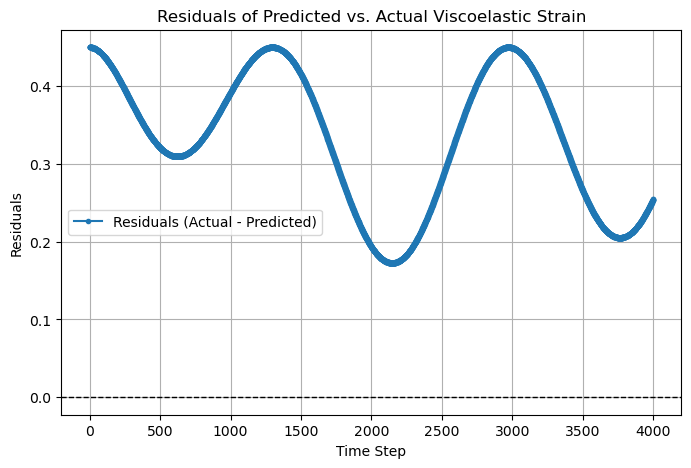

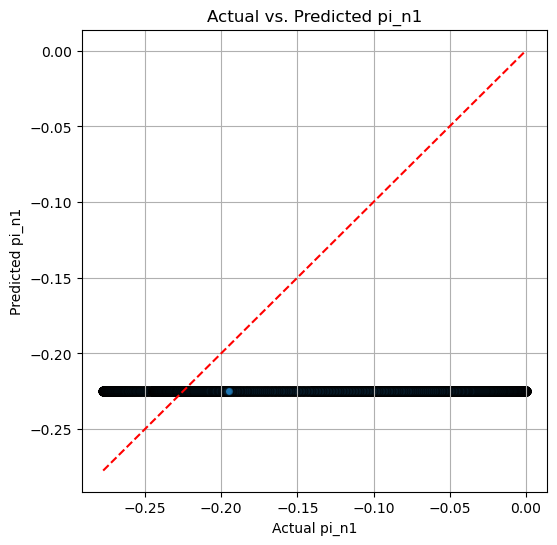

In [19]:


# Compute Mean Squared Error (MSE)
mse = np.mean((pi_n1 - predictions_1) ** 2)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(pi_n1 - predictions_1))

# Compute R-squared (R²)
ss_total = np.sum((pi_n1 - np.mean(pi_n1)) ** 2)
ss_residual = np.sum((pi_n1 - predictions_1) ** 2)
r2 = 1 - (ss_residual / ss_total)

# Compute Pearson Correlation Coefficient (r)
pearson_corr, _ = pearsonr(pi_n1, predictions_1)

# Print the metrics
print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'R^2: {r2:.6f}')
print(f'Pearson Correlation: {pearson_corr:.6f}')

# Residual Plot
plt.figure(figsize=(8, 5))
residuals = pi_n1 - predictions_1 -predictions_1[0]
plt.plot(residuals, label='Residuals (Actual - Predicted)', linestyle='-', marker='o', markersize=3)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero error line
plt.xlabel("Time Step")
plt.ylabel("Residuals")
plt.legend()
plt.title("Residuals of Predicted vs. Actual Viscoelastic Strain")
plt.grid()
plt.show()

# Scatter Plot for Actual vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(pi_n1, predictions_1, alpha=0.7, edgecolors='k')
plt.plot([min(pi_n1), max(pi_n1)], [min(pi_n1), max(pi_n1)], 'r--')  # Perfect fit line
plt.xlabel("Actual pi_n1")
plt.ylabel("Predicted pi_n1")
plt.title("Actual vs. Predicted pi_n1")
plt.grid()
plt.show()
